In [2]:
!pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import plot_tree

from sklearn import tree
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

In [4]:
def preprocess_data(file_path='synthetic_data_dt.csv'):
    data = pd.read_csv(file_path)
    label_encoder = LabelEncoder()
    data['Diagnosis'] = label_encoder.fit_transform(data['Diagnosis'])
    X = data[['HeartRate']]
    y = data['Diagnosis']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    return X_train, X_test, y_train, y_test, label_encoder

In [5]:
X_train, X_test, y_train, y_test,label_encoder = preprocess_data()

clf = DecisionTreeClassifier(max_leaf_nodes=3, random_state=0)
clf.fit(X_train, y_train)

DecisionTreeClassifier(max_leaf_nodes=3, random_state=0)

In [6]:
n_nodes = clf.tree_.node_count
children_left = clf.tree_.children_left
children_right = clf.tree_.children_right
feature = clf.tree_.feature
threshold = clf.tree_.threshold
values = clf.tree_.value

node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
is_leaves = np.zeros(shape=n_nodes, dtype=bool)
stack = [(0, 0)]  # start with the root node id (0) and its depth (0)
while len(stack) > 0:
    # `pop` ensures each node is only visited once
    node_id, depth = stack.pop()
    node_depth[node_id] = depth

    # If the left and right child of a node is not the same we have a split
    # node
    is_split_node = children_left[node_id] != children_right[node_id]
    # If a split node, append left and right children and depth to `stack`
    # so we can loop through them
    if is_split_node:
        stack.append((children_left[node_id], depth + 1))
        stack.append((children_right[node_id], depth + 1))
    else:
        is_leaves[node_id] = True

print(
    "The binary tree structure has {n} nodes and has "
    "the following tree structure:\n".format(n=n_nodes)
)
for i in range(n_nodes):
    if is_leaves[i]:
        print(
            "{space}node={node} is a leaf node with value={value}.".format(
                space=node_depth[i] * "\t", node=i, value=np.around(values[i], 3)
            )
        )
    else:
        print(
            "{space}node={node} is a split node with value={value}: "
            "go to node {left} if X[:, {feature}] <= {threshold} "
            "else to node {right}.".format(
                space=node_depth[i] * "\t",
                node=i,
                left=children_left[i],
                feature=feature[i],
                threshold=threshold[i],
                right=children_right[i],
                value=np.around(values[i], 3),
            )
        )

The binary tree structure has 5 nodes and has the following tree structure:

node=0 is a split node with value=[[0.316 0.351 0.333]]: go to node 1 if X[:, 0] <= 100.5 else to node 2.
	node=1 is a split node with value=[[0.333 0.667 0.   ]]: go to node 3 if X[:, 0] <= 58.5 else to node 4.
	node=2 is a leaf node with value=[[0.296 0.    0.704]].
		node=3 is a leaf node with value=[[1. 0. 0.]].
		node=4 is a leaf node with value=[[0. 1. 0.]].


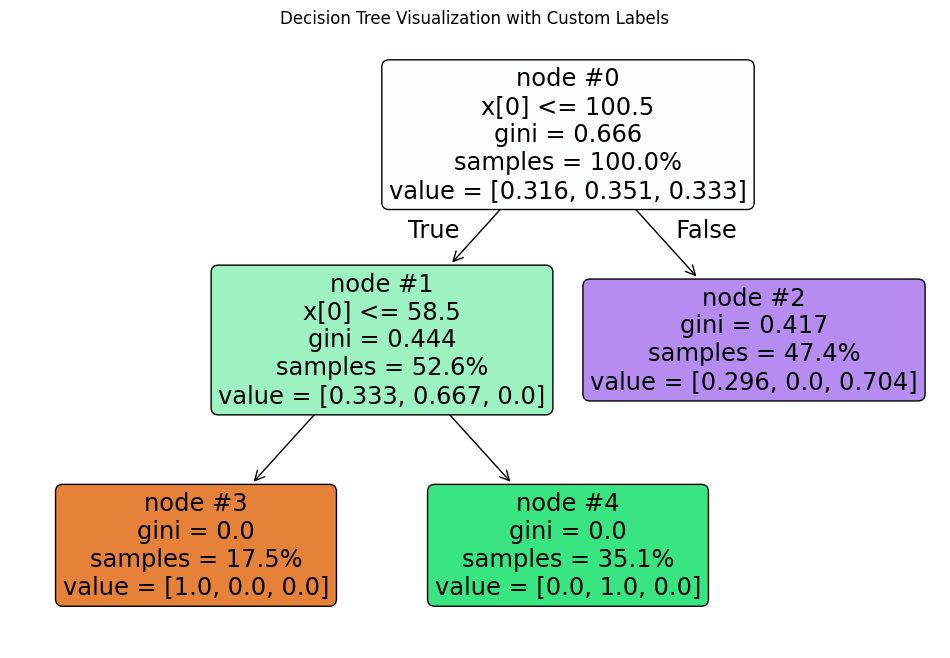

In [7]:
X_train, X_test, y_train, y_test, label_encoder = preprocess_data()

# Train the DecisionTreeClassifier on the training data
clf = DecisionTreeClassifier(max_leaf_nodes=3, random_state=0)
clf.fit(X_train, y_train)

# Get the value counts at each node
node_values = clf.tree_.value
class_labels = label_encoder.classes_

# Create custom labels for the tree nodes
def create_labels(node_values, class_labels):
    labels = []
    for values in node_values:
        # Get the index of the class with the highest count
        predicted_class_index = np.argmax(values)
        predicted_class = class_labels[predicted_class_index]
        
        # Create a label with counts
        label = f"{predicted_class}\nCounts: {values.astype(int)}"
        labels.append(label)
    return labels

# Create labels for each node
labels = create_labels(node_values, class_labels)

# Plot the decision tree
plt.figure(figsize=(12, 8))
plot_tree(clf, 
          filled=True, 
          proportion=True, 
          node_ids=True,  # Show node IDs for reference
          rounded=True)

plt.title("Decision Tree Visualization with Custom Labels")
plt.show()

In [15]:

# Obtain the decision path and leaf nodes for the samples in X_test
node_indicator = clf.decision_path(X_test)
leaf_id = clf.apply(X_test)

# Select a sample to interpret
sample_id = 11

# Get the feature and threshold used in each decision node
feature = clf.tree_.feature
threshold = clf.tree_.threshold

# Obtain the indices of the nodes that sample `sample_id` goes through
node_index = node_indicator.indices[
    node_indicator.indptr[sample_id] : node_indicator.indptr[sample_id + 1]
]

print(f"Rules used to predict sample {sample_id}:\n")
for node_id in node_index:
    # Continue to the next node if it's a leaf node
    if leaf_id[sample_id] == node_id:
        continue

    # Determine if the value of the split feature is below or above the threshold
    # If X_test is a DataFrame, convert to a Numpy array to use indices
    sample_value = X_test.iloc[sample_id, feature[node_id]] if isinstance(X_test, pd.DataFrame) else X_test[sample_id, feature[node_id]]
    
    if sample_value <= threshold[node_id]:
        threshold_sign = "<="
    else:
        threshold_sign = ">"

    print(
        f"Decision node {node_id} : (X_test[{sample_id}, {feature[node_id]}] = {sample_value}) "
        f"{threshold_sign} {threshold[node_id]}"
    )

Rules used to predict sample 11:

Decision node 0 : (X_test[11, 0] = 97) <= 100.5
Decision node 1 : (X_test[11, 0] = 97) > 58.5


In [17]:
heart_rate_value = 46  # Replace this with the heart rate you want to predict
input_data = np.array([[heart_rate_value]])  # Shape it to be 2D: (n_samples, n_features)

predicted_class_index = clf.predict(input_data)

# Decode the predicted class back to original label using the label encoder
predicted_class_label = label_encoder.inverse_transform(predicted_class_index)

print(f"Predicted condition for heart rate {heart_rate_value}: {predicted_class_label[0]}")

Predicted condition for heart rate 46: Arrhythmia


C:\Users\cheta\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
